## Setup
- load train and test datasets, create TensorFlow Datasets from them
- define main architecutre params

In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import absolute_import, division, print_function

import logging
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import skimage

from src.data_utils import Dataset
from src.network import unet_3d

# tf.enable_eager_execution()

# get TF logger - set it to info for more tracking process
log = logging.getLogger('tensorflow')
log.setLevel(logging.DEBUG)

In [2]:
batch_size = 2
train_dataset = Dataset.load_dataset(
    '../data/processed/train_dataset.pckl'
).create_tf_dataset().shuffle(50).repeat().padded_batch(
    batch_size=batch_size,
    padded_shapes=([32, 128, 128, 1], [32, 128, 128, 3]))
test_dataset = Dataset.load_dataset(
    '../data/processed/test_dataset.pckl'
).create_tf_dataset().shuffle(50).repeat().padded_batch(
    batch_size=batch_size,
    padded_shapes=([32, 128, 128, 1], [32, 128, 128, 3]))

# setup dataset iterator objects, idea from:
# http://adventuresinmachinelearning.com/tensorflow-dataset-tutorial/
iterator = tf.data.Iterator.from_structure(
    train_dataset.output_types,
    train_dataset.output_shapes
)
training_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)
next_element = iterator.get_next()

In [3]:
# create the neural network model
train_phase = tf.placeholder(tf.bool, name="is_training")
logits = unet_3d(next_element[0], training=train_phase, depth=3, n_base_filters=4)

# add the optimizer and weigthed softmax loss
# see https://stackoverflow.com/a/44563055
class_weights = np.array([0.00408978, 0.70013423, 0.295776])
class_weights = tf.cast(tf.constant(class_weights), tf.float32)
# deduce weights for batch samples based on their true label
class_weights = tf.reduce_sum(tf.cast(next_element[0], tf.float32) * class_weights, axis=-1)
loss = tf.losses.softmax_cross_entropy(logits=logits, onehot_labels=next_element[1], weights=class_weights)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = tf.train.AdamOptimizer().minimize(loss)
    
# get accuracy
prediction = tf.argmax(logits, axis=-1)
labels = tf.argmax(next_element[1], -1)
equality = tf.equal(prediction, labels)
accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))

# get mean iou
iou, conf_mat = tf.metrics.mean_iou(
    labels=labels, 
    predictions=tf.cast(prediction, tf.int32),
    num_classes=3
)

# setup variables for training
train_n = 70
test_n = 10
epochs = 100

# run the training
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
sess.run(training_init_op)
saver = tf.train.Saver()

for i in range(epochs * train_n):
    # how to run tf.metrics, idea taken from: https://stackoverflow.com/a/46414395
    l, _, acc, _, _ = sess.run([loss, train_op, accuracy, iou, conf_mat], feed_dict={train_phase:True})
    miou = sess.run([iou])
    if i % 50 == 0:
        print("Epoch: {}, loss: {:.3f}, training accuracy: {:.2f}%".format(i, l, acc * 100))
        print("Epoch: {}, loss: {:.3f}, training IOU: {:.2f}%".format(i, l, miou[0] * 100))


# re-initialize the iterator, but this time with test data
sess.run(test_init_op)
test_iters = epochs * test_n
avg_acc = 0
avg_miou = 0
for i in range(test_iters):
    acc, miou = sess.run([accuracy, iou], feed_dict={train_phase:False})
    avg_acc += acc
    avg_miou += miou
print("Average test set accuracy over {} iterations is {:.2f}%".format(test_iters, (avg_acc / test_iters) * 100))
print("Average test set IOU over {} iterations is {:.2f}%".format(test_iters, (avg_miou / test_iters) * 100))

save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in path: %s" % save_path)

DEBUG:tensorflow:conv1: (?, 32, 128, 128, 4)
DEBUG:tensorflow:conv2: (?, 32, 128, 128, 8)
DEBUG:tensorflow:maxpool layer: (?, 16, 64, 64, 8)
DEBUG:tensorflow:conv1: (?, 16, 64, 64, 8)
DEBUG:tensorflow:conv2: (?, 16, 64, 64, 16)
DEBUG:tensorflow:maxpool layer: (?, 8, 32, 32, 16)
DEBUG:tensorflow:conv1: (?, 8, 32, 32, 16)
DEBUG:tensorflow:conv2: (?, 8, 32, 32, 32)
DEBUG:tensorflow:upconv layer: (?, 16, 64, 64, 32)
DEBUG:tensorflow:concat layer: (?, 16, 64, 64, 16)
DEBUG:tensorflow:up_conv layer1: (?, 16, 64, 64, 16)
DEBUG:tensorflow:up_conv layer2 : (?, 16, 64, 64, 16)
DEBUG:tensorflow:upconv layer: (?, 32, 128, 128, 16)
DEBUG:tensorflow:concat layer: (?, 32, 128, 128, 8)
DEBUG:tensorflow:up_conv layer1: (?, 32, 128, 128, 8)
DEBUG:tensorflow:up_conv layer2 : (?, 32, 128, 128, 8)
DEBUG:tensorflow:output layer:: (?, 32, 128, 128, 3)
Epoch: 0, loss: 0.142, training accuracy: 72.92%
Epoch: 0, loss: 0.142, training IOU: 24.66%
Epoch: 50, loss: 0.051, training accuracy: 69.10%
Epoch: 50, loss:

In [63]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('../models/bs2_d3_f4_e200/model.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))

[autoreload of pkg_resources.extern.packaging failed: Traceback (most recent call last):
  File "/home/daniel/.virtualenvs/tf/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/daniel/.virtualenvs/tf/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/daniel/.virtualenvs/tf/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/daniel/.virtualenvs/tf/lib/python3.5/importlib/__init__.py", line 147, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module pkg_resources._vendor.packaging not in sys.modules
]
[autoreload of pkg_resources.extern.six failed: Traceback (most recent call last):
  File "/home/daniel/.virtualenvs/tf/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/hom

ValueError: Can't load save_path when it is None.

In [4]:
sess.run(test_init_op)
y_pred, y_true = sess.run([prediction, labels], feed_dict={train_phase: False})    

In [25]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

sess.run(test_init_op)
y_pred, y_true = sess.run([prediction, labels], feed_dict={train_phase: False})    


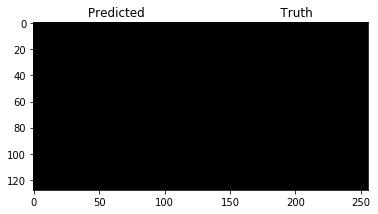

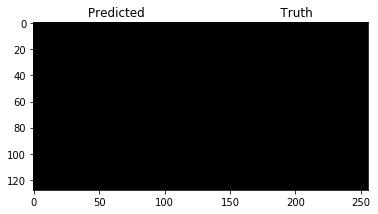

In [62]:
i = 1
p=y_pred[i] 
t=y_true[i]
ys = np.concatenate((p, t), axis=2)
fig, ax = plt.subplots()
for i, scan in enumerate(ys):
    plt.imshow(scan, cmap=plt.cm.bone)
    plt.title('Predicted                                   Truth')
    clear_output(wait=True)
    display(fig)
plt.show()